#                                      Sentiment Analysis on Anime Reviews 

* ## 0 Introduction 
    * ### 0.1 Import Libraries
    * ### 0.2 Loading the Database 

* ## 1 Exploratory Data Analysis 
    * ### 1.1 Data Exploration 
    * #### 1.1.1 Rating Frequency Table
        * #### 1.1.2 Word Cloud 
    * ### 1.2 Data Cleaning 
    * ### 1.3 Data Split - only get rTrain
    * ### 1.4 Word Frequency Table 
    * ### 1.5  Import Sentiment Weights 

* ## 2 Train Models 

## 0. Introduction 

A Japanese anime, from Chinese viewing website called bilibili.com, which went IPO in NY Exchange as ticker (BILI). The reviews are scrapped from the website using JSON and till the end of the date of May 6, 2019. 

* Question: 
* Source: 
* Conclusion: 

## Note: 
Test data is split half (train/test) and then 70-30, containing 2258 comments. 

### 0.1 Import Libraries 

In [1]:
import os 
import sys 
import re

import scipy
import numpy as np
import pandas as pd
import jieba.analyse
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# import sklearn modules 
import sklearn.metrics as skm
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.metrics import confusion_matrix as skm_conf_mat
from collections import Counter
from collections import defaultdict

### 0.2 Loading the Dataset

In [2]:
original_df = pd.read_pickle("/Users/apple/Desktop/ADEC7430 BIg Data Econometrics/Final/gzxb.pkl")
datas = pd.read_csv("/Users/apple/Desktop/ADEC7430 BIg Data Econometrics/Final/bilibilib_gongzuoxibao.csv", sep = ",")

## 1. Exploratory Data Analysis 
### 1.1. Data Exploration 

In [3]:
colnames = datas.columns
print(colnames) # author, score, disliked, likes, liked, ctime, score.1, content, last_ex_index, cursor, date

Index(['author', 'score', 'disliked', 'likes', 'liked', 'ctime', 'content',
       'last_ep_index', 'cursor', 'date'],
      dtype='object')


In [4]:
datas.shape

(19063, 10)

#### 1.1.1 Rating Frequency Table

In [5]:
datas['score'].value_counts()

10    17480
8       933
6       292
2       272
4        86
Name: score, dtype: int64

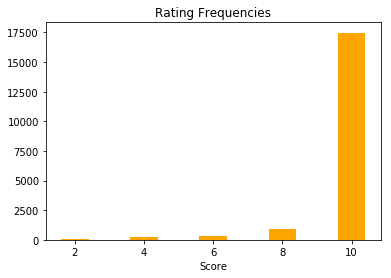

In [6]:
x = [2,4,6,8,10]
#y = [272,86,292,933,17480]
y = list(datas['score'].value_counts())[::-1]
plt.bar(x,y, color='orange')
plt.xlabel('Score')
plt.ylabel('')
plt.title('Rating Frequencies')
plt.show()

> Cutting Words/Parsle 

In [7]:
#%% Content Analysis 
texts = ';'.join(datas['content'].tolist())
cut_text = " ".join(jieba.cut(texts))
# TF_IDF
keywords = jieba.analyse.extract_tags(cut_text, topK=100, withWeight=True, allowPOS=('a','e','n','nr','ns'))
text_cloud = dict(keywords)
###pd.DataFrame(keywords).to_excel('TF_IDF关键词前100.xlsx')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/4h/8s1vtfjn6q96ftrjbs27q_k40000gn/T/jieba.cache
Loading model cost 1.297 seconds.
Prefix dict has been built succesfully.


In [8]:
# Remove all punctuation and expression marks 
temp =  "\\【.*?】+|\\《.*?》+|\\#.*?#+|[.!/_,$&%^*()<>+""'?@|:~{}#]+|[——！\\\，。=？、：“”‘’￥……（）《》【】]"
cut_text = re.sub(pattern = temp, repl = "", string = cut_text)

#### 1.1.2 Word Cloud

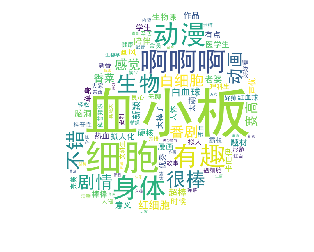

In [9]:
bg = plt.imread("血小板.jpg")
# Specify font 
font = r'/Users/apple/Documents/simhei.ttf'
wc = WordCloud(# FFFAE3
    collocations=False, 
    font_path=font,
    background_color="white", 
    width=400, 
    height=600, 
    mask=bg,
    random_state = 2,
    max_font_size=500, 
    #font_path="STSONG.TTF",  
).generate_from_frequencies(text_cloud)

plt.imshow(wc)
plt.axis("off")
plt.show()

### 1.2. Data Cleaning 

In [10]:
del datas['ctime']
del datas['cursor']
del datas['liked']
del datas['disliked']
del datas['likes']
del datas['last_ep_index']
pd.isnull(datas).astype(int).aggregate(sum, axis = 0)

author     0
score      0
content    0
date       0
dtype: int64

> saving dataset to pickle in case

datas['content'].to_pickle("/Users/apple/Desktop/ADEC7430 BIg Data Econometrics/Final/gzxb.pkl")

### 1.3. Data Split

In [11]:
content_df = pd.read_pickle("/Users/apple/Desktop/ADEC7430 BIg Data Econometrics/Final/gzxb.pkl")
content_df.describe()

count     19063
unique    16231
top          好看
freq        316
Name: content, dtype: object

In [12]:
# split the train data into train1 (for modeling) and train2 (for testing, out of sample accuracy measures)
import random
random.seed(2019)
randommask = [x < 0.5 for x in [random.uniform(0,1) for y in range(content_df.shape[0])]]

train1 = content_df.loc[randommask].copy()
train2 = content_df.loc[[not x for x in randommask]].copy()
randommask = [x < 0.7 for x in [random.uniform(0,1) for y in range(train1.shape[0])]]
train3 = train1.loc[randommask].copy()
train4 = train1.loc[[not x for x in randommask]].copy()

rTrain = train3
rValidation = train4
rTest = train2

# let's understand up a bit the data
## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(rTrain.shape), 
      "\nValidation set: \t{}".format(rValidation.shape),
      "\nTest set: \t\t{}".format(rTest.shape))

			Feature Shapes:
Train set: 		(6553,) 
Validation set: 	(2894,) 
Test set: 		(9616,)


In [13]:
rTrain.head(10)

12    题材新颖    剧情也不错    作画也很好    最重要的是声优阵容豪华
15                                 希望有第二季！！
19                              是我在b站看过最好的番
20                           很棒！狗粮真好吃真好吃！！！
25                          让我了解到了很多生活方面的知识
31                              好看好看~大爱工作细胞
33                                 很有意思 很可爱
36                                  买了白哥手办！
37                                       。。
43                小时候最喜欢生物，虽然学不了，但我还是想一直关注她
Name: content, dtype: object

In [14]:
perfect = datas[datas.score == 10]
imperfect = datas[datas.score != 10]
perfect_sample = perfect.sample(n = 1583, random_state = 1 )
new_data = pd.concat([perfect_sample, imperfect], axis = 0)

In [17]:
randommask = [x < 0.7 for x in [random.uniform(0,1) for y in range(new_data.shape[0])]]
rTrain = new_data.loc[randommask].copy()
rTest = new_data.loc[[not x for x in randommask]].copy()
print(rTrain.shape, rTest.shape)

(2177, 4) (989, 4)


> saving dataset to pickle in case

rTrain.to_pickle("/Users/apple/Desktop/ADEC7430 BIg Data Econometrics/Final/rTrain.pkl")
rTest.to_pickle("/Users/apple/Desktop/ADEC7430 BIg Data Econometrics/Final/rTest.pkl")

In [18]:
rTrain = pd.read_pickle("rTrain.pkl")
rTest = pd.read_pickle("rTest.pkl")
# let's understand up a bit the data
## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(rTrain.shape), 
      #"\nValidation set: \t{}".format(rValidation.shape),
      "\nTest set: \t\t{}".format(rTest.shape))

			Feature Shapes:
Train set: 		(2258, 4) 
Test set: 		(908, 4)


### 1.4. Frequency Table for Top 100 

rTrain.to_pickle("/Users/apple/Desktop/ADEC7430 BIg Data Econometrics/Final/rTrain.pkl")
> y_rTrain; > y_rTest

In [19]:
yTrain = rTrain['score']
yTest = rTest['score']

In [20]:
texts = '\n'.join(rTrain['content'].tolist())
#cut_text = jieba.lcut(texts)
cut_text = "".join(jieba.cut(texts))
cut_text = re.sub(pattern = temp, repl = "", string = cut_text)

keyword = jieba.analyse.extract_tags(cut_text, topK=100, allowPOS=('a','e','n','nr','ns'))  # list
cut_text = cut_text.split('\n')
keyword

['血小板',
 '细胞',
 '剧情',
 '不错',
 '有趣',
 '啊啊啊',
 '感觉',
 '生物',
 '动画',
 '动漫',
 '身体',
 '番剧',
 '有点',
 '很棒',
 '白细胞',
 '新颖',
 '无聊',
 '题材',
 '香菜',
 '红细胞',
 '白血球',
 '声优',
 '癌细胞',
 '脑洞',
 '拟人化',
 '意义',
 '画风',
 '很好',
 '作品',
 '超棒',
 '赛高',
 '优秀',
 '安利',
 '漫画',
 '会员',
 '一般',
 '人物',
 '时候',
 '单身',
 '老婆',
 '评分',
 '硬核',
 '热血',
 '套路',
 '陪伴',
 '作画',
 '弹幕',
 '红血球',
 '文科生',
 '故事',
 '卡哇伊',
 '科普知识',
 '棒棒',
 '细菌',
 '亮点',
 '科普性',
 '新意',
 '理科生',
 '人体',
 '医学生',
 '严谨',
 '学生',
 '轻松',
 '角色',
 '精良',
 '地方',
 '女主',
 '大家',
 '内容',
 '情节',
 '良心',
 '尴尬',
 '拟人',
 '兴趣',
 '个人',
 '节奏',
 '好帅',
 '霸权',
 '生物学',
 '画面',
 '老少皆宜',
 '老套',
 '完美',
 '迷路',
 '总体',
 '谢谢',
 '一星',
 '作者',
 '真棒',
 '方面',
 '老师',
 '方式',
 '幼稚',
 '帅气',
 '白哥',
 '肥宅',
 '路痴',
 '看点',
 '观众',
 '类型']

In [21]:
#%%多个循环实现每条评论的词频统计
cutlist = []

for i in range(0, len(cut_text)):
    cut_dic = defaultdict(int) #词频不叠加，每次统计一个句子后就清空
    comment = cut_text[i]
    comment_cut = jieba.lcut(comment)
    for word in comment_cut: # word freq for every comment 
        if word in keyword:
            cut_dic[word] += 1  
    order = sorted(cut_dic.items(),key = lambda x:x[1],reverse = True) # word freq in descending order
    #print(order)
 
    myresult = "" #字典不叠加，每次统计一个句子后就清空
    for j in range(0,len(order)):#把每条评论的词频统计结果保存为str格式
        result = order[j][0]+ "-" + str(order[j][1])
        myresult = myresult + " " + result #myresult和result的顺序不能换，否则就变升序啦 
    cutlist.append(myresult)
#print(cutlist)

In [22]:
word_freqs = []
for raw in cutlist:
    word_freq = {}
    for word_freq_raw in raw.split():
        index = word_freq_raw.find('-')
        word = word_freq_raw[:index]
        freq = int(word_freq_raw[index + 1])
        word_freq[word] = freq
    word_freqs.append(word_freq)
    
matrix = []
for word_freq in word_freqs:
    row = []
    for word in keyword:
        if word in word_freq:
            row.append(word_freq[word])
        else:
            row.append(0)
    matrix.append(row)
#print(matrix)
matrix = np.array(matrix)

In [23]:
labels = []
for i in range(len(matrix)):
    phaseID = "c" + str(i+1)
    labels.append(phaseID)

df = pd.DataFrame(data = dict(zip(labels,matrix)))#, index=[0]

### 1.5. Import Sentiment Weights 
> X_rTrain

In [32]:
grade = np.array([0.1,0,0,0.7,0.8,0.5,0.1,0,0,0,0,0,0,1,0.1,0.8,-0.7,0,0.3,0.1,0.1,0.2,0,0.3,0.5,0.6,0.6,0.9,0,1,1,1,1,0,0.1,-0.1,0,0,0,0.7,0,0.7,0.8,-0.2,0.6,0,0,0.1,0,0,0.9,0.6,1,0,0,0.5,0.7,0,0,0,0.5,0,0.6,0,0.8,0,0.3,0,0,0,0.8,-1,0.4,0.6,0,0,0.8,-0.5,0,0.3,0.7,-0.7,1,0,0,0.7,-1,0,1,0,0.2,0,-0.8,0.6,0.4,-0.6,-0.1,0.1,0,0])

In [70]:
X = np.array(matrix) * grade

In [59]:
yTrain.shape

(2258,)

## 2. Train Model 
### 2.1. Logistic Regression

In [75]:
# import Logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X, yTrain)
clf.score(X, yTrain)

0.5336581045172719

In [79]:
np.unique(clf.predict(X))

array([ 2,  6,  8, 10])

### 2.2 Gaussian Naive Bayes

In [74]:
#Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(X, yTrain)
gnb.score(X,yTrain)

0.10008857395925598

In [83]:
gnb.predict(X)
np.unique(gnb.predict(X))

array([ 2,  4,  6,  8, 10])

In [115]:
xTrain = pd.read_csv("X.csv")
y0 = pd.read_csv("y0.csv")

y0 = y0.iloc[:, 1:2]

### 2.3 Random Forests 

In [104]:
import sklearn.metrics as skm
from sklearn.ensemble import RandomForestClassifier as RFClass
model_rf = RFClass(n_estimators = 100, max_depth=5, random_state=2019)
model_rf.fit(X, yTrain)
model_rf.score(X, yTrain)

0.524800708591674

In [106]:
model_rf.predict(X)
np.unique(gnb.predict(X))

array([ 2,  4,  6,  8, 10])